In [9]:
from getpass import getpass
token = getpass('Enter your GitHub token: ')



Enter your GitHub token: ··········


#CoOP
This notebook performs CoOP using CLIP, This notebook performs fewshot leanrning (1,2...16) on various context length, on different class token position (front, mid, end) on various models.

#Configurations

In [1]:
colab_clone_repo = True

In [ ]:
test_dataset_name = 'caltech'   #['airplane', 'caltech', 'dtd', 'flower', 'food', 'pets', 'ucf']
model_name = "ViT-B/16" #['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']
path=f"output/{model_name}/{test_dataset_name}/coop_prompt.pth" # Model save path
# mention all the parameters
n_ctx = 16  # few shot learning (1,2,....16)
ctx_init = ""  # context vector, rn its not initialized
class_token_position = "end"  #["front", "middle", "end"]
csc = False  # For using the class specific context
input_size = 224  # Input Image
# if csc is True then initialize it with "photo of a" or else False then use the generic
if not ctx_init:
    if csc:
        ctx_init = "a photo of a"
    else:
        ctx_init = ""

#Prepare the Execution Environment

In [10]:
# Change the path if necessary
dataset_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if colab_clone_repo and not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone https://{token}@github.com/oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    if colab_clone_repo:
        %cd /content/applied-ml/
    else:
        %cd /content/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

Looks that a private key is already created. If you have already push it to github, no action required.
 Otherwise, Please go to https://github.com/settings/ssh/new to upload the following key: 
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIACg2Ls9J77YFA3SsrCO1KByupjJeYLcMYUTBjtbG4Bu root@e1f18cb72fab

Please use SSH method to clone repo.
/content
Cloning into 'applied-ml'...
remote: Enumerating objects: 403, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 403 (delta 17), reused 22 (delta 10), pack-reused 362 (from 1)
Receiving objects: 100% (403/403), 161.49 MiB | 50.34 MiB/s, done.
Resolving deltas: 100% (196/196), done.
/content/applied-ml
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha

In [11]:
!pip install torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

In [12]:
if not os.path.exists('CoOp'):
  !git clone https://github.com/KaiyangZhou/CoOp.git

Cloning into 'CoOp'...
remote: Enumerating objects: 455, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 455 (delta 217), reused 198 (delta 198), pack-reused 205 (from 1)
Receiving objects: 100% (455/455), 1.40 MiB | 9.02 MiB/s, done.
Resolving deltas: 100% (266/266), done.


In [29]:
import torch
import torchvision
import torchvision.transforms as transforms
import clip
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import random_split
import clip
import os.path as osp
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.cuda.amp import GradScaler, autocast
from clip import clip
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import aml.datasets
import os
import sys
import argparse
from clip.simple_tokenizer import SimpleTokenizer
from clip import clip
_tokenizer = _Tokenizer()

#Load the CLIP Model

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load(model_name, device=device)

100%|███████████████████████████████████████| 335M/335M [00:06<00:00, 56.2MiB/s]


#Data Loading and Data Processing

In [16]:
# set the transform variable according to the models architecture
transform = preprocess
match test_dataset_name:
    case 'airplane':
        dataset = aml.datasets.FGVCAircraft(root=dataset_path,split='train', transform=preprocess)
    case 'caltech':
        dataset = aml.datasets.Caltech101(root=dataset_path,split='train', transform=preprocess)
    case 'dtd':
        dataset = aml.datasets.DTD(root=dataset_path,split='train', transform=preprocess)
    case 'flower':
        dataset = aml.datasets.Flowers102(root=dataset_path,split='train', transform=preprocess)
    case 'food':
        dataset = aml.datasets.Food101(root=dataset_path,split='train', transform=preprocess)
    case 'pets':
        dataset = aml.datasets.OxfordIIITPet(root=dataset_path,split='train', transform=preprocess)
    case 'ucf':
        dataset = aml.datasets.UCF101(root=dataset_path,split='train', transform=preprocess)

classnames = dataset.classnames

Downloading...
From (original): https://drive.google.com/uc?id=1IFqrvpdbrpmI6DPntopcPY6svPu04uYD
From (redirected): https://drive.usercontent.google.com/download?id=1IFqrvpdbrpmI6DPntopcPY6svPu04uYD&confirm=t&uuid=432622c6-6538-4ab7-abd1-6d1140ae18c6
To: /content/applied-ml/datasets/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:01<00:00, 86.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1sW96Lj6yLIujKpopd8tBrIO_NCaKBy5d
From (redirected): https://drive.usercontent.google.com/download?id=1sW96Lj6yLIujKpopd8tBrIO_NCaKBy5d&confirm=t&uuid=19c6402e-fdba-4ec9-8562-a7fc405d188b
To: /content/applied-ml/datasets/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 74.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hyarUivQE36mY6jSomru6Fjd-JzwcCzN
To: /content/applied-ml/datasets/caltech101/split.json
100%|██████████| 809k/809k [00:00<00:00, 168MB/s]


In [17]:
# Split the data into 80/20 split
num_train = int(0.8 * len(dataset))
num_val = len(dataset) - num_train
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

#Set up the train and val dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)

#TEXT ENCODER

In [18]:
# Retruns the text feature vector of shape (batchsize, embedding)
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        # Model to process the token Embeddings
        self.transformer = clip_model.transformer
        # Positional Encoder
        self.positional_embedding = clip_model.positional_embedding
        # Clip final layer
        self.ln_final = clip_model.ln_final
        # A learned projection matrix that maps the final hidden state to the CLIP embedding space.
        self.text_projection = clip_model.text_projection
        # Model data type
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
        #adds the positional embedding to the token embedding, which includes the information about the token position
        x = prompts + self.positional_embedding.type(self.dtype)
        # Changes shape from (batch_size, seq_len, dim) → (seq_len, batch_size, dim)
        x = x.permute(1, 0, 2)
        #Passes the sequence through the Transformer (learns contextual relationships between tokens).
        x = self.transformer(x)
        # Reverts the shape back to (batch_size, seq_len, dim).
        x = x.permute(1, 0, 2)
        # Applies layer normalization and converts to the appropriate data type.
        x = self.ln_final(x).type(self.dtype)
        # Selects the embedding at the position of the end-of-text token, assuming it's the most meaningful. and projects the token into clip embedding space
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection
        return x

#Prompt Learner

In [19]:
class PromptLearner(nn.Module):
    def __init__(self, classnames, clip_model, n_ctx=16, ctx_init="", class_token_position="end", csc=False, input_size=224):
        super().__init__()
        self.n_cls = len(classnames) # total classnames
        self.n_ctx = n_ctx # Number of learnable context tokens
        self.ctx_init = ctx_init # String to initialize the context from words
        self.class_token_position = class_token_position # class token position (front, middle,  end)
        self.csc = csc # True / False value to use one prompt per class
        self.input_size = input_size # Image resolution

        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]
        clip_imsize = clip_model.visual.input_resolution
        device = clip_model.token_embedding.weight.device

        assert self.input_size == clip_imsize, f"cfg_imsize ({self.input_size}) must equal to clip_imsize ({clip_imsize})"

        # if the string is provided to initialize the context this perform the below block ("a photo of a")
        if self.ctx_init:
            # replaces the underscore of the string to spaces
            ctx_init = self.ctx_init.replace("_", " ")
            # updates the n_ctx ( number of learnable tokens) based on how many words are in the prompt. here its 4 as ("a photo of a")
            self.n_ctx = len(ctx_init.split(" "))
            # Tokenize the prompt, output shape- [1,77]
            prompt = clip.tokenize(ctx_init).to(device)
            # converts the tokenized prompts imto embeddings, output shape - [1, 77, ctx_dim]
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            #extract the embedding for the context words not for the special tokens, [sos], [eos]
            ctx_vectors = embedding[0, 1 : 1 + self.n_ctx, :].to(device)
            # stores the original ctx_init prompt
            prompt_prefix = ctx_init
        # if the string is not provided the perform the below code
        else:
            # if csc is true which works for the class specific prompts the perform the below code
            if self.csc:
                print("Initializing class-specific contexts")
                # creates separate set of learnable context tokens for each number of class (n_cls)
                ctx_vectors = torch.empty(self.n_cls, self.n_ctx, ctx_dim, dtype=dtype, device=device) # size of [100, 16, 512] for 100 classes, 16 context length and 512 embedding
            # if False then perform the below code
            else:
                print("Initializing a generic context")
                # single set of context tokens for all classes
                ctx_vectors = torch.empty(self.n_ctx, ctx_dim, dtype=dtype, device=device) #output shape of [16, 512] for ctx = 16, ctx_dim=512
            # randomly initializing the context vector (ctx_vector) from the normal distribution
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * self.n_ctx)

        print(f'Initial context: "{prompt_prefix}"') # prints number of X for n_ctx
        print(f"Number of context words (tokens): {self.n_ctx}")

        #wraps into nn.Parameter making them trainable weights
        self.ctx = nn.Parameter(ctx_vectors)

        # data cleaning, replaces the underscore in the class names with the space
        classnames = [name.replace("_", " ") for name in classnames]
        # stores the length of the tokens of each class name
        self.name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        # creates the string stored in prompts variable with class names
        prompts = [prompt_prefix + " " + name + "." for name in classnames]
        # clip.tokenize tokenize all class prompts into sequence of token ID and send to the device
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(device) #output size of [n_cls, 77] number of class and 77 clip input size
        # convert the token ids in the tokenized_prompt variable into embeddings layer
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype) # output shape [n_cls, 77, ctx_dim]
        # start of the token (special token) not trainable, so set it as fixed buffer
        self.register_buffer("token_prefix", embedding[:, :1, :])
        # end of the token as well, not trainable
        self.register_buffer("token_suffix", embedding[:, 1 + self.n_ctx :, :])

        # stores the original token IDs
        self.tokenized_prompts = tokenized_prompts

    # Assembles the final prompt embeddings for each class, the output of this are input to the text encoder
    def forward(self):
        ctx = self.ctx
        # if the context is shared that is [n_ctx, ctx_dim] no n_cls then expands this same context for all the classes [n_cls, n_ctx, ctx_dim]
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        prefix = self.token_prefix # get the starting token
        suffix = self.token_suffix # get the end token

        # This works on the position of the class token provided (end, middle, front)
        if self.class_token_position == "end":
            #prompt is in form- [start token, context, classname, end token] simple contactenation
            prompts = torch.cat([prefix, ctx, suffix], dim=1)

        # For Middle position
        elif self.class_token_position == "middle":
            half_n_ctx = self.n_ctx // 2 # get the middle
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]
                prompt = torch.cat([prefix_i, ctx_i_half1, class_i, ctx_i_half2, suffix_i], dim=1)
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0) #prompt is in form- [start token, context, classname, context, end token] simple contactenation

        # For front position
        elif self.class_token_position == "front":
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i = ctx[i : i + 1, :, :]
                prompt = torch.cat([prefix_i, class_i, ctx_i, suffix_i], dim=1)
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0) #prompt is in form- [start token, classname, context, end token] simple contactenation

        else:
            raise ValueError(f"Invalid class_token_position: {self.class_token_position}")

        return prompts, self.tokenized_prompts # returns prompt tensor of shape [n_cls, sequence lenght (context), ctx_dim] and tokenized_prompt with token_ids

#Clip Model

In [20]:
class CustomCLIP(nn.Module):
    def __init__(self, classnames, clip_model):
        super().__init__()
        # creates a learnable prompt for each class
        self.prompt_learner = PromptLearner(
            classnames=classnames,
            clip_model=clip_model,
            n_ctx=16,
            ctx_init="",
            csc=False,
            class_token_position="end",
            input_size=224
        )
        #loads clip vision encoder
        self.image_encoder = clip_model.visual
        #text encoder
        self.text_encoder = TextEncoder(clip_model)
        #use to scale similarity logits ( this helps in improving the convergance)
        self.logit_scale = clip_model.logit_scale
        # clip model tensor data type
        self.dtype = clip_model.dtype

    def forward(self, image):
      # encodes the image, outputs the image features vectors
        image_features = self.image_encoder(image.type(self.dtype))
        # generate prompts and tokenized prompts with token IDs from the prompt learner class we declared above
        prompts, tokenized_prompts = self.prompt_learner()
        # encodes the prompts and tokenized output from the prompt learner into the text encoder of the model
        text_features = self.text_encoder(prompts, tokenized_prompts)
        # Normalizing the image and text features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        # Computing the similaritys
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits # returns [batch_size, num_classes] this later gets passed into the training

#Initialize the CLIP model

In [21]:
model = CustomCLIP(classnames=classnames, clip_model=clip_model).to(device) # Initialize the object from the CustomClip class above which takes the classnames and model as an input

Initializing a generic context
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16


#Set the hyperparameters for the model training

In [22]:
# setting the hyperparameters as per the paper
MAX_EPOCH = 200
LR = 0.002
optimizer = optim.SGD(model.prompt_learner.parameters(), lr=LR, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=MAX_EPOCH)
criterion = torch.nn.CrossEntropyLoss()

#Function to save the model weights

In [23]:
#function to save the trained model
def save_prompt_learner(model, model_name, dataset_name):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({"state_dict": model.prompt_learner.state_dict()}, path)
    print(f"Prompt learner saved to {path}")

#Training Loop

In [24]:
# training loop
PRINT_FREQ = 5
for epoch in range(MAX_EPOCH):
    # puts the model in the training mode
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    #iterate through train_loader batches
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # zero the gradients from the previous batch
        optimizer.zero_grad()
        # forward pass
        logits = model(images)
        # compute loss
        loss = criterion(logits, labels)
        # backpropagrate
        loss.backward()
        optimizer.step()

        # Accumulate loss, compute results
        running_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % PRINT_FREQ == 0:
            print(f"Epoch [{epoch+1}/{MAX_EPOCH}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    acc = 100. * correct / total #accuracy of the model
    print(f"Epoch {epoch+1}: Train Loss = {running_loss:.4f}, Accuracy = {acc:.2f}%")

    scheduler.step()
# set the model in the evaluation mode, over the validation dataset and get predictions
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {100.0 * correct / total:.2f}%")

Epoch [1/200], Batch [5/104], Loss: 0.3879
Epoch [1/200], Batch [10/104], Loss: 0.1249
Epoch [1/200], Batch [15/104], Loss: 0.0741
Epoch [1/200], Batch [20/104], Loss: 0.2224
Epoch [1/200], Batch [25/104], Loss: 0.0834
Epoch [1/200], Batch [30/104], Loss: 0.0414
Epoch [1/200], Batch [35/104], Loss: 0.1237
Epoch [1/200], Batch [40/104], Loss: 0.0342
Epoch [1/200], Batch [45/104], Loss: 0.1918
Epoch [1/200], Batch [50/104], Loss: 0.1531
Epoch [1/200], Batch [55/104], Loss: 0.0736
Epoch [1/200], Batch [60/104], Loss: 0.0807
Epoch [1/200], Batch [65/104], Loss: 0.2379
Epoch [1/200], Batch [70/104], Loss: 0.0643
Epoch [1/200], Batch [75/104], Loss: 0.1512
Epoch [1/200], Batch [80/104], Loss: 0.1106
Epoch [1/200], Batch [85/104], Loss: 0.1661
Epoch [1/200], Batch [90/104], Loss: 0.1387
Epoch [1/200], Batch [95/104], Loss: 0.1880
Epoch [1/200], Batch [100/104], Loss: 0.0390
Epoch 1: Train Loss = 18.8350, Accuracy = 94.43%
Epoch [2/200], Batch [5/104], Loss: 0.1008
Epoch [2/200], Batch [10/104

TypeError: save_prompt_learner() missing 2 required positional arguments: 'model_name' and 'dataset_name'

In [25]:
# save the model .pth file
save_prompt_learner(model=model,model_name=model_name,dataset_name=test_dataset_name)

Prompt learner saved to output/ViT-B/16/caltech/coop_prompt.pth


#Prompt Interpretation

Interprets the learned context vectors from the saved CoOp prompt learner. It maps them to the closest real words in CLIP vocabulary. It helps explaining what the learned context tokens represent in natural language

In [27]:
def interpret_prompt(fpath, topk=5, model_name=model_name): #f_Path is .pth file, topk: number of top closest tokens to show per context vector
    assert os.path.exists(fpath), f"Prompt file not found: {fpath}"
    print(f"Return the top-{topk} matched words")

    # loads the clip model and a token embedding
    tokenizer = SimpleTokenizer()
    clip_model = clip.load(model_name, device="cpu")[0]  # Use same model backbone
    token_embedding = clip_model.token_embedding.weight
    print(f"Size of token embedding: {token_embedding.shape}")

    #load the trained prompt learner
    prompt_learner = torch.load(fpath, map_location="cpu")["state_dict"]
    # trained context embedding
    ctx = prompt_learner["ctx"].float()
    print(f"Size of context: {ctx.shape}")

    # This is for the shared context
    if ctx.dim() == 2:
        #computes the euclidean distance between each context token and each real token
        distance = torch.cdist(ctx, token_embedding)
        print(f"Size of distance matrix: {distance.shape}")
        sorted_idxs = torch.argsort(distance, dim=1)[:, :topk]

        for m, idxs in enumerate(sorted_idxs):
            words = [tokenizer.decoder[idx.item()] for idx in idxs] # here the tokenizer.decoder helps to decodes the closest token into actual works
            dist = [f"{distance[m, idx].item():.4f}" for idx in idxs]
            print(f"{m+1}: {words} {dist}")

    elif ctx.dim() == 3:
        raise NotImplementedError("Class-specific context interpretation not supported.")


#Interpret Prompts Results

NUmbers on left (1:16) context vectors learned, the list shows top-5 closest vocabulary tokens (Decoded) for thier respective context vector

In [30]:
interpret_prompt(path, topk=5, model_name=model_name)

Return the top-5 matched words
Size of token embedding: torch.Size([49408, 512])
Size of context: torch.Size([16, 512])
Size of distance matrix: torch.Size([16, 49408])
1: ['Ę</w>', 'Ď</w>', 'ď</w>', 'Đ</w>', 'đ</w>'] ['0.5561', '0.5561', '0.5561', '0.5561', '0.5561']
2: ['mikequind', 'ó</w>', 'ė</w>', 'Ė</w>', 'ĕ</w>'] ['0.6559', '0.6590', '0.6590', '0.6590', '0.6590']
3: ['pknot</w>', 'Ç</w>', 'I</w>', 'Æ</w>', 'Å</w>'] ['0.6629', '0.6640', '0.6640', '0.6640', '0.6640']
4: ['requi', 'commod', 'read', 'setti</w>', 'monetary</w>'] ['1.0789', '1.0815', '1.0824', '1.0830', '1.0831']
5: ['polar', 'atility</w>', 'calle', 'coscino</w>', 'pational</w>'] ['0.8004', '0.8014', '0.8021', '0.8022', '0.8027']
6: ['sundaywithmarsha</w>', 'kirstel</w>', 'ę</w>', 'Đ</w>', 'đ</w>'] ['0.5346', '0.5378', '0.5389', '0.5389', '0.5389']
7: ['ė</w>', 'č</w>', 'Ď</w>', 'ď</w>', 'Đ</w>'] ['0.5942', '0.5942', '0.5942', '0.5942', '0.5942']
8: ['pational</w>', 'sundaywithmarsha</w>', 'Ë</w>', 'Õ</w>', 'Ô</w>'] [

#Comparison with CLIP

In [31]:
def evaluate_model(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100. * correct / total


In [35]:
# Load zero-shot model (no prompt weights loaded)
clip_model, _ = clip.load(model_name, device=device)
zero_shot_model = CustomCLIP(classnames, clip_model).to(device)

# Load trained CoOp model
trained_model = CustomCLIP(classnames, clip_model).to(device)
ckpt = torch.load(path, map_location="cpu")
trained_model.prompt_learner.load_state_dict(ckpt["state_dict"])

# Compare
acc_zero = evaluate_model(zero_shot_model, val_loader, device)
acc_coop = evaluate_model(trained_model, val_loader, device)

print(f"\nClassification Accuracy Comparison:")
print(f"Zero-shot CLIP   : {acc_zero:.2f}%")
print(f"CoOp : {acc_coop:.2f}%")

Initializing a generic context
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16
Initializing a generic context
Initial context: "X X X X X X X X X X X X X X X X"
Number of context words (tokens): 16

Classification Accuracy Comparison:
Zero-shot CLIP   : 77.72%
CoOp : 96.85%


#Visualisations

In [33]:
def visualize_tsne(model, val_loader, classnames):
    model.eval()
    features = []
    labels_list = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(next(model.parameters()).device).type(model.dtype)
            feats = model.image_encoder(images)
            features.append(feats.cpu())
            labels_list.extend(labels.cpu())

    features = torch.cat(features).numpy()
    labels_list = torch.tensor(labels_list).numpy()

    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(features)

    # Plot all points colored by class
    plt.figure(figsize=(10, 8))
    num_classes = len(classnames)
    cmap = plt.get_cmap("tab20")

    for class_idx in range(num_classes):
        idxs = labels_list == class_idx
        coords = reduced[idxs]
        plt.scatter(coords[:, 0], coords[:, 1], s=5, color=cmap(class_idx % 20), alpha=0.6)

        # Plot class number at mean location
        center_x = coords[:, 0].mean()
        center_y = coords[:, 1].mean()
        plt.text(center_x, center_y, str(class_idx), fontsize=10, weight="bold", color=cmap(class_idx % 20))

    plt.title("t-SNE of CLIP Image Features CoOP")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

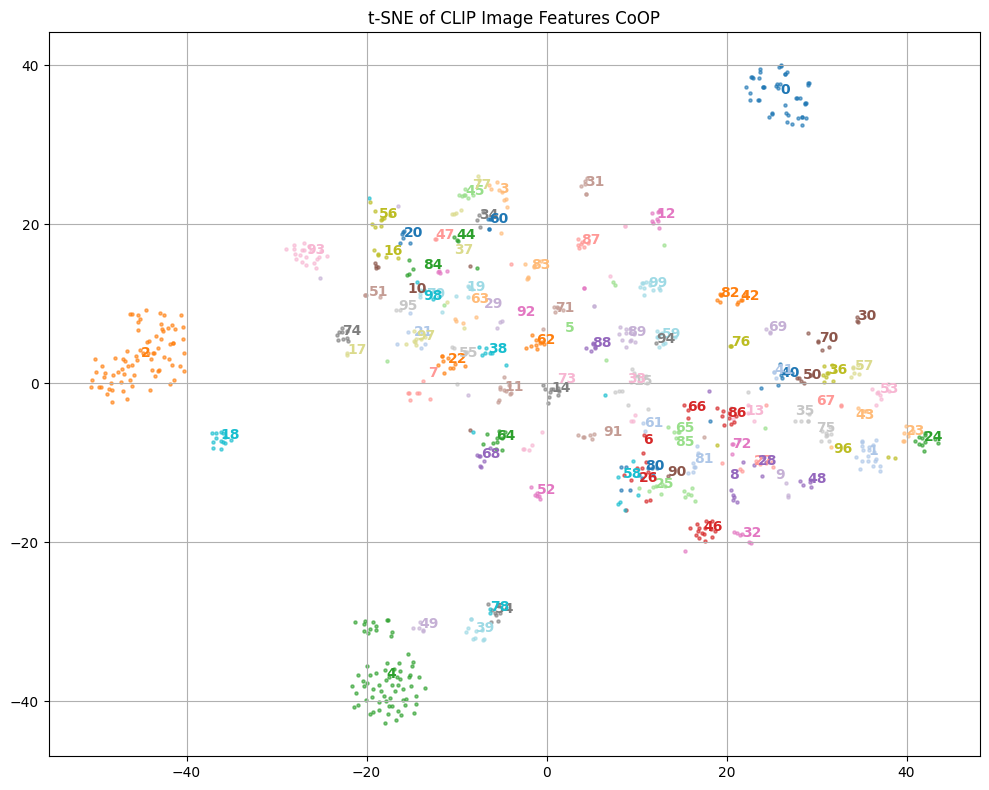

In [34]:
visualize_tsne(model, val_loader, classnames)